<a href="https://colab.research.google.com/github/doxuansang/LSTM_analysis/blob/main/LSTM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

pandas

In [1]:
import pandas as pd
import numpy as np

import datetime module

In [2]:
from datetime import date
from dateutil.rrule import rrule, DAILY

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
from sklearn.preprocessing import MinMaxScaler

tensorflow

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, LSTM

Select companies for analysis<br>
Enter the company's stock code<br>
"FPT", "MSN", "PNJ" or "VIC"

In [6]:
com = "MSN"

load data

In [7]:
com_file = com.upper() + ".csv"
df_input = pd.read_csv(com_file)
df_input.head()

FileNotFoundError: ignored

standardize data types

In [ ]:
df_input["Date/Time"] = pd.to_datetime(df_input["Date/Time"]).dt.date
df_input["Date/Time"] = pd.to_datetime(df_input["Date/Time"])


<br>
After reading the data, we can realize that the time interval between any two rows is not equal<br>
There are days when there are only a few rows of data, and there are days when there is a lot of data<br>
Therefore, it is necessary to simplify and optimize input data<br>
We will combine all rows in 1 day into a single row, with:<br>
 + Ticker: the same<br>
 + Date: that day (skip time)<br>
 + Open: first open price of the day<br>
 + High: highest price of the day<br>
 + Low: lowest price of the day<br>
 + Close: last close price of the day<br>
 + Volume: total trading volume of the day<br>
 + Open Interest: ignore :)))<br>


create main dataframe for processing

In [ ]:
df = pd.DataFrame(columns=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

initializing the start and end date

In [ ]:
start_date = df_input['Date/Time'][0]
end_date = df_input['Date/Time'][len(df_input) - 1]
# iterating over the dates
for d in rrule(DAILY, dtstart=start_date, until=end_date):
    date_check = pd.to_datetime(d.strftime("%Y-%m-%d"))
    # check if that date exists or not?
    # Vietnam's stock market has a day off
    if(date_check in df_input['Date/Time'].values):
        df_sub = df_input[df_input['Date/Time'].dt.strftime('%Y-%m-%d') == d.strftime("%Y-%m-%d")]
        df.loc[len(df.index)] = [df_input['Ticker'][0], d.strftime("%Y-%m-%d"), df_sub.head(1)['Open'].values, df_sub['High'].max(), df_sub['Low'].min(), df_sub.tail(1)['Close'].values, df_sub['Volume'].sum()]

Try drawing a data chart after optimization

In [ ]:
plt.figure(figsize=(16, 8))
#plt.plot(df_input["Close"], label='Input')
#plt.plot(df["Close"], label='Optimized')
#plt.show()

process input data

In [ ]:
data = df.sort_index(ascending=True, axis=0)
# analysis based on closing prices
new_dataset = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

In [ ]:
for i in range(0, len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close"][i] = data["Close"][i]

In [ ]:
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)

80% train, 20% test<br>
in this case 400 days

In [ ]:
train_data = new_dataset[:400]
test_data = new_dataset[400:]

setting a range helps the program run faster

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(new_dataset.values)

In [ ]:
x_train, y_train = [], []

predict results with input data from the previous 30 days

In [ ]:
for i in range(30, len(train_data)):
    x_train.append(scaled_data[i - 30:i, 0])
    y_train.append(scaled_data[i, 0])

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

LSTM

In [ ]:
model = Sequential()
# two stacked LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))

the hidden state output of each neuron is used as input to the next LSTM layer

In [ ]:
model.add(LSTM(units=50, activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mse')
save_it = model.fit(x_train, y_train, epochs=30, validation_split=0.2, verbose=1, batch_size=5)

save model

In [ ]:
model.save("model_lstm.h5")

input data for testing

In [ ]:
input_data = new_dataset[len(new_dataset) - len(test_data) - 30:].values
input_data = input_data.reshape(-1, 1)
input_data = scaler.transform(input_data)

test

In [ ]:
X_test = []
for i in range(30, input_data.shape[0]):
    X_test.append(input_data[i - 30:i, 0])
X_test = np.array(X_test)

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Draw a chart showing stock price fluctuations and predicted results

In [ ]:
test_data.loc[:, ('Predictions')] = closing_price
plt.title('Actual vs Predicted for open price ({})'.format(com), size=15)
plt.xticks(range(0, df.shape[0], 15), df['Date'].loc[::15], rotation=45)
plt.xlabel('Date', size=15)
plt.ylabel('Stock Price (Close)', size=15)
plt.plot(new_dataset["Close"], label='Actual')
plt.plot(test_data[["Predictions"]], label='Predictions')
plt.legend()
fig_name = com + '_test'
plt.savefig(fig_name)
plt.show()

4 charts showing stock price movements and predicted results of 4 companies

Link: https://drive.google.com/drive/folders/1_1yxVJf2XRQmBTLpAZQjIRlIfAoxcap9?usp=sharing

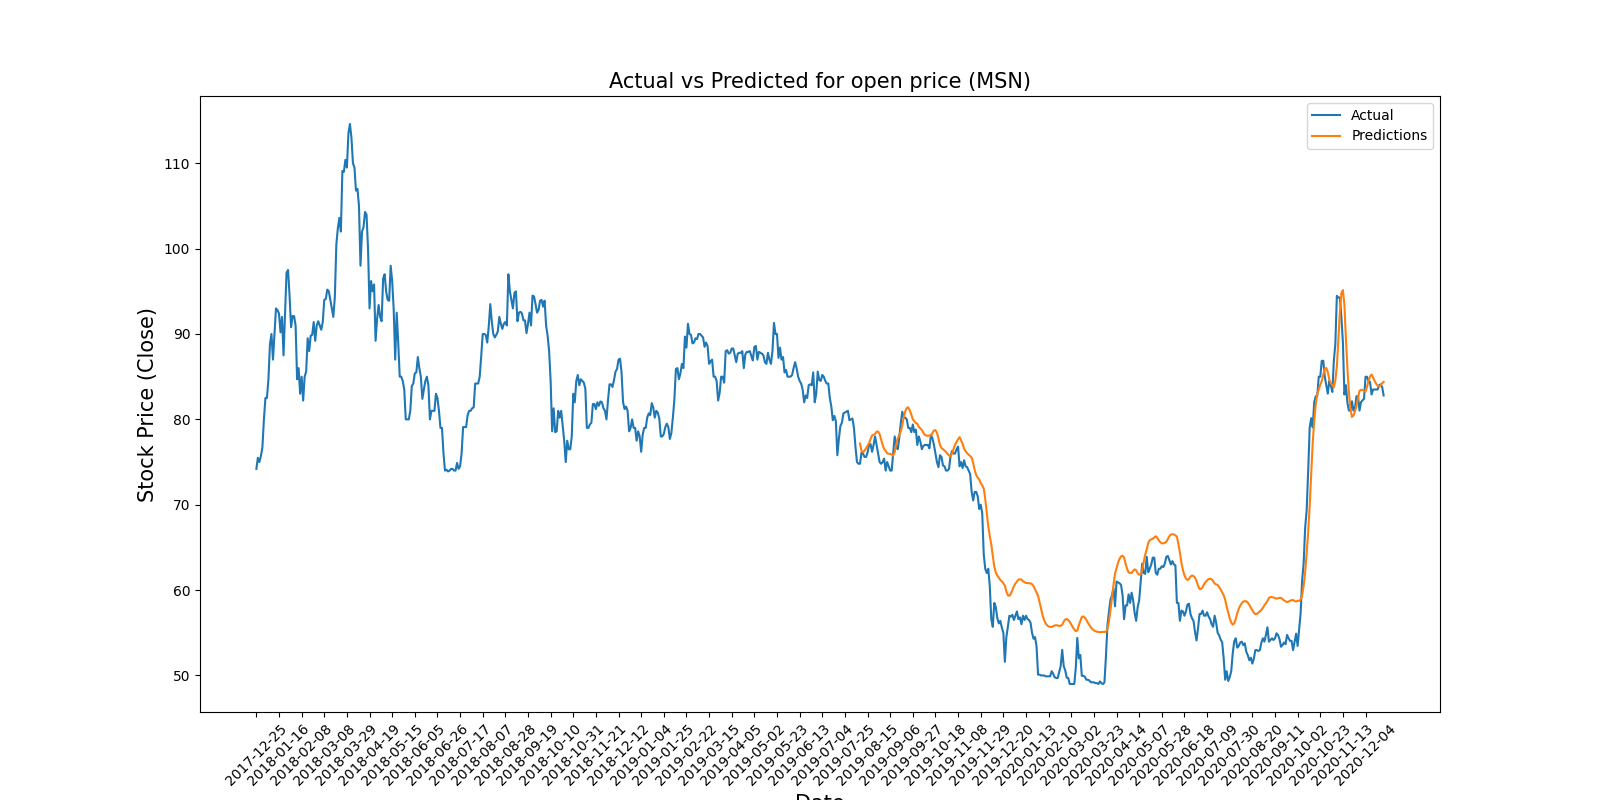

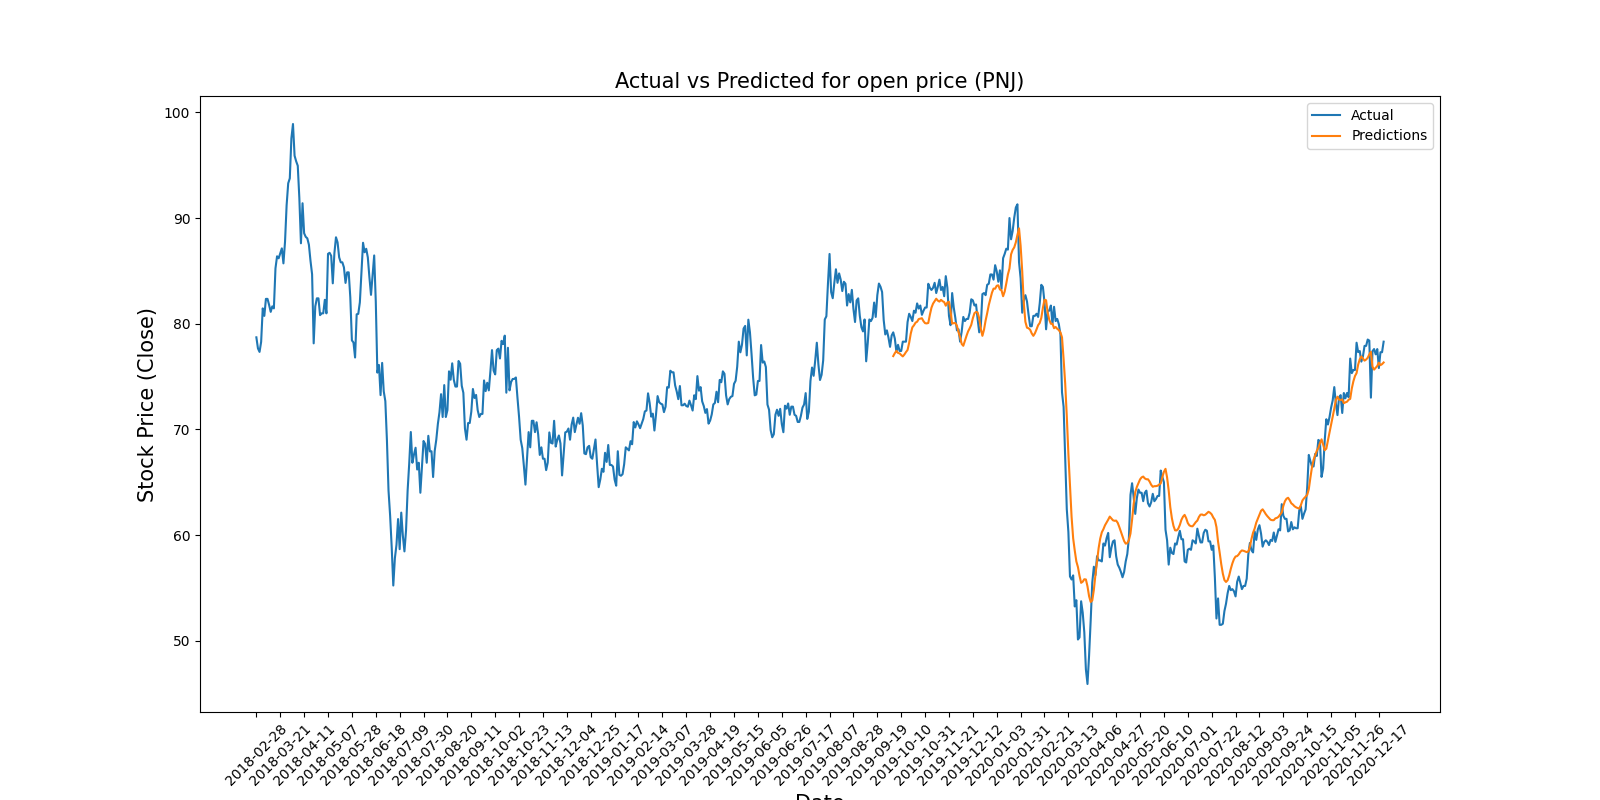

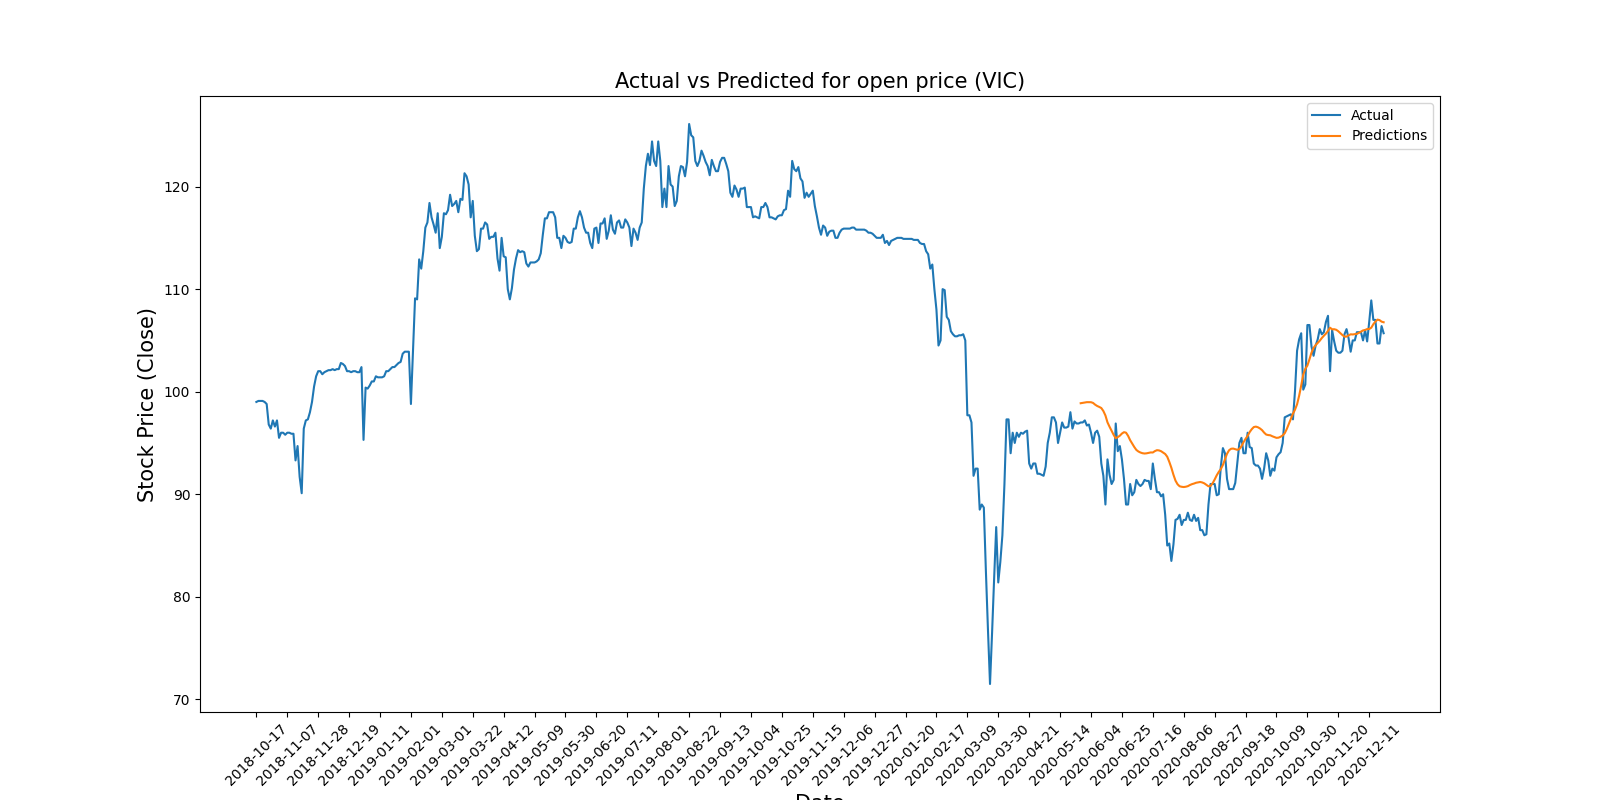

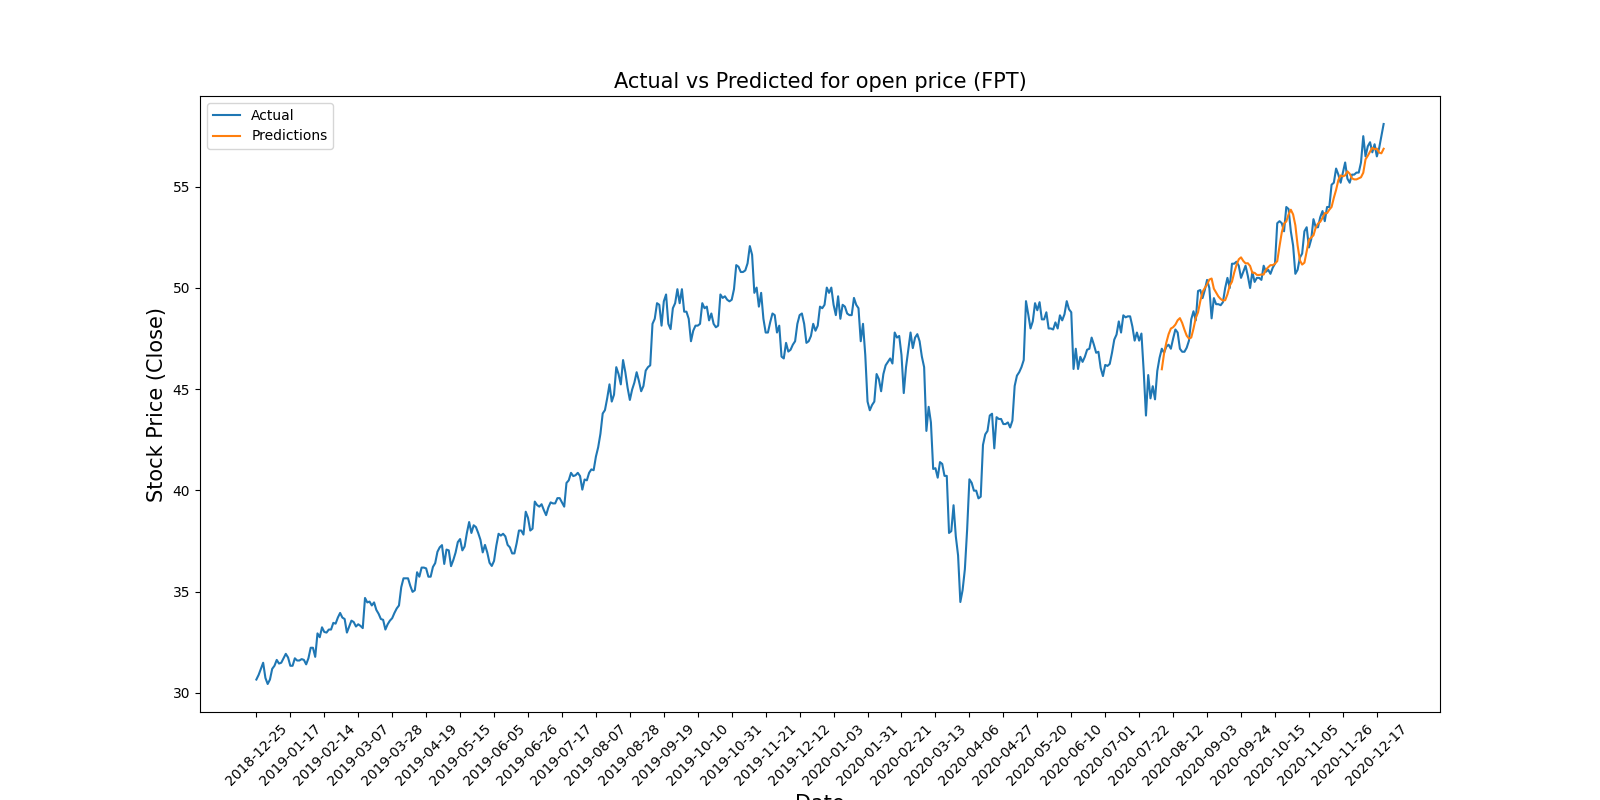